In [1]:
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF
import os
import warnings
import os, sys
import numpy as np
import keras
import cv2
from skimage import io,transform
from tflearn.layers.conv import global_avg_pool
from keras.models import Model
from keras.layers import Input, Dense, Activation, Flatten, Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.models import Model
from keras import layers
from keras import backend as K
from keras.utils import np_utils
from keras.optimizers import SGD
from keras.callbacks import Callback

C:\Users\s110024\AppData\Local\conda\conda\envs\ML2018\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Instructions for updating:
Use the retry module or similar alternatives.
curses is not supported on this machine (please install/reinstall curses for an optimal experience)


In [2]:
#进行配置，使用40%的GPU
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
session = tf.Session(config=config)
# 设置session
KTF.set_session(session )

In [3]:
def VGG16(input_tensor=None, input_shape=None):

    img_input = Input(shape=input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)


    # Classification block
    x = Flatten(name='flatten')(x)
    #x = Dense(4096, activation='relu', name='fca')(x)
    #x = Dense(4096, activation='relu', name='fcb')(x)
    x = Dense(40, activation='softmax', name='Classification')(x)

    inputs = img_input
    # Create model.
    model = Model(inputs, x, name='vgg16')

    return model

In [4]:
def loading(dirs = os.getcwd()):

    trainMatrix = []
    trainLabel = []
    testMatrix = []
    testLabel = []
    countOfPeople = 0
    for i in range(1, 40):
        if i == 14:
            continue
        file = os.path.join(dirs, 'CroppedYale', 'yaleB%02d' % i, '*.pgm')
        rawImg = io.imread_collection(file)
        
        imgs = np.array([cv2.resize(img, (224,224), interpolation = cv2.INTER_CUBIC) for img in rawImg])
        imgs = np.array(imgs, dtype=np.int64)
        
        countOfPeople = len(imgs)
        #print(countOfPeople)
        
        train = imgs[0:35]
        trainMatrix.append(train)
        for j in range(0, 35): trainLabel.append(i)
            
        test = imgs[countOfPeople-30:countOfPeople]
        testMatrix.append(test)
        for j in range(0, 30): testLabel.append(i) 

        
    return trainMatrix, trainLabel, testMatrix, testLabel

In [5]:
trainMatrix, trainLabel, testMatrix, testLabel = loading(os.getcwd())


trainCount = np.size(trainLabel, 0)
testCount = np.size(testLabel, 0)

trainMatrix = np.array(trainMatrix).reshape(trainCount,224,224,1)

# change one channel to three
original = trainMatrix
trainMatrix = np.resize(trainMatrix,(trainCount,224,224,3))
trainMatrix[:,:,:,0:1] = original
trainMatrix[:,:,:,1:3] = 0     #channel two and three = 0


testMatrix = np.array(testMatrix).reshape(testCount,224,224,1)

# change one channel to three
original = testMatrix
testMatrix = np.resize(testMatrix,(testCount,224,224,3))
testMatrix[:,:,:,0:1] = original
testMatrix[:,:,:,1:3] = 0



print("TrainCount: %d" % trainCount)
print("TestCount: %d" % testCount)

TrainCount: 1330
TestCount: 1140


In [6]:
trainLabel_encode = np_utils.to_categorical(trainLabel, num_classes=40)
testLabel_encode = np_utils.to_categorical(testLabel, num_classes=40)
print(trainLabel_encode)

[[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [7]:
model = VGG16(input_shape=[224, 224, 3])
sgd = SGD(lr=0.0001, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
history = model.fit(trainMatrix, trainLabel_encode, epochs=100, batch_size=32, 
                    validation_data=(testMatrix, testLabel_encode), verbose=1)

Train on 1330 samples, validate on 1140 samples
Epoch 1/100
1330/1330 [==============================] - 147s 111ms/step - loss: 3.7024 - acc: 0.0256 - val_loss: 3.6925 - val_acc: 0.0237
Epoch 2/100
1330/1330 [==============================] - 108s 81ms/step - loss: 3.6906 - acc: 0.0248 - val_loss: 3.6870 - val_acc: 0.0246
Epoch 3/100
1330/1330 [==============================] - 114s 86ms/step - loss: 3.6817 - acc: 0.0248 - val_loss: 3.6826 - val_acc: 0.0254
Epoch 4/100
1330/1330 [==============================] - 111s 84ms/step - loss: 3.6743 - acc: 0.0256 - val_loss: 3.6789 - val_acc: 0.0272
Epoch 5/100
1330/1330 [==============================] - 110s 83ms/step - loss: 3.6678 - acc: 0.0248 - val_loss: 3.6754 - val_acc: 0.0281
Epoch 6/100
1330/1330 [==============================] - 109s 82ms/step - loss: 3.6619 - acc: 0.0263 - val_loss: 3.6722 - val_acc: 0.0263
Epoch 7/100
1330/1330 [==============================] - 115s 87ms/step - loss: 3.6560 - acc: 0.0271 - val_loss: 3.6694 - v

Epoch 60/100
1330/1330 [==============================] - 88s 66ms/step - loss: 0.5987 - acc: 0.9504 - val_loss: 5.7803 - val_acc: 0.3491
Epoch 61/100
1330/1330 [==============================] - 83s 62ms/step - loss: 0.5657 - acc: 0.9496 - val_loss: 6.1724 - val_acc: 0.3421
Epoch 62/100
1330/1330 [==============================] - 88s 66ms/step - loss: 0.5423 - acc: 0.9549 - val_loss: 6.5427 - val_acc: 0.3184
Epoch 63/100
1330/1330 [==============================] - 82s 62ms/step - loss: 0.5163 - acc: 0.9526 - val_loss: 6.4090 - val_acc: 0.3307
Epoch 64/100
1330/1330 [==============================] - 88s 66ms/step - loss: 0.2971 - acc: 0.9534 - val_loss: 6.1582 - val_acc: 0.3474
Epoch 65/100
1330/1330 [==============================] - 83s 62ms/step - loss: 0.1153 - acc: 0.9842 - val_loss: 6.1626 - val_acc: 0.3465
Epoch 66/100
1330/1330 [==============================] - 87s 65ms/step - loss: 0.0992 - acc: 0.9865 - val_loss: 6.2764 - val_acc: 0.3500
Epoch 67/100
1330/1330 [==========

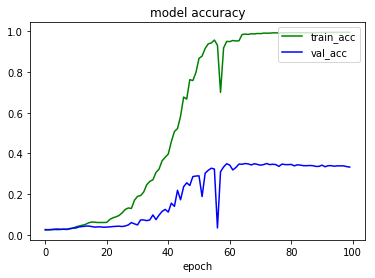

In [8]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'], 'g', label='train_acc')
plt.plot(history.history['val_acc'], 'b', label='val_acc')
plt.legend(loc='upper right')
plt.title('model accuracy')
plt.xlabel('epoch')
plt.show()

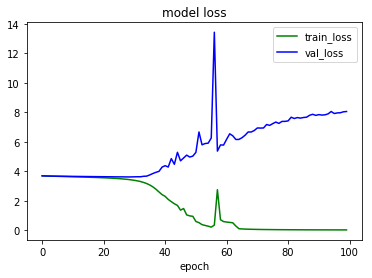

In [9]:
plt.plot(history.history['loss'], 'g', label='train_loss')
plt.plot(history.history['val_loss'], 'b', label='val_loss')
plt.legend(loc='upper right')
plt.title('model loss')
plt.xlabel('epoch')
plt.show()

In [10]:
loss, acc = model.evaluate(x = testMatrix, y = testLabel_encode, batch_size = 32)
print("loss : ", loss)
print("accuracy : ", acc)

1140/1140 [==============================] - 16s 14ms/step
loss :  8.053018941377339
accuracy :  0.3324561403639484
